# 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. 데이터로더 구성

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3. 모델 구성을 위한 데이터 분석 및 가공
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [5]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
index_to_word

{3: '',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95: '시간',
 96: '지루',
 97: '중',
 98: '재미있',
 99: '

In [8]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[0])    
print(word_to_index['<PAD>'])
print(index_to_word[1])    

<PAD>
0
<BOS>


In [9]:
# 정상적으로 decode되는지 확인해 보겠습니다.

print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [10]:
# 전체 데이터 셋 분포 확인

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [11]:
# 문장 최대길이에 맞춰서 앞쪽에 패딩 채우기

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


In [12]:
# validation set

X_val = X_train[:11000]   
y_val = y_train[:11000]

partial_X_train = X_train[11000:]  
partial_y_train = y_train[11000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(135182, 41)
(135182,)


In [13]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

print('done')

done


# 4. 모델 구성

In [14]:
# LSTM

LSTM = keras.Sequential()
LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
LSTM.add(keras.layers.Dense(8, activation='relu'))
LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1312      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 321,393
Trainable params: 321,393
Non-trainable params: 0
_________________________________________________________________


In [15]:
# CNN

CNN = keras.Sequential()
CNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
CNN.add(keras.layers.MaxPooling1D(5))
CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
CNN.add(keras.layers.GlobalMaxPooling1D())
CNN.add(keras.layers.Dense(8, activation='relu'))
CNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          3600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [16]:
# GlobalMaxPooling

Global = keras.Sequential()
Global.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
Global.add(keras.layers.GlobalMaxPooling1D())
Global.add(keras.layers.Dense(8, activation='relu'))
Global.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

Global.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 320,273
Trainable params: 320,273
Non-trainable params: 0
_________________________________________________________________


# 5. 학습

## LSTM

In [17]:
LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_LSTM = LSTM.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
265/265 [==============================] - 7s 15ms/step - loss: 0.6267 - accuracy: 0.6309 - val_loss: 0.3809 - val_accuracy: 0.8377
Epoch 2/10
265/265 [==============================] - 3s 11ms/step - loss: 0.3508 - accuracy: 0.8543 - val_loss: 0.3596 - val_accuracy: 0.8475
Epoch 3/10
265/265 [==============================] - 3s 12ms/step - loss: 0.3166 - accuracy: 0.8679 - val_loss: 0.3422 - val_accuracy: 0.8515
Epoch 4/10
265/265 [==============================] - 3s 11ms/step - loss: 0.2992 - accuracy: 0.8759 - val_loss: 0.3436 - val_accuracy: 0.8495
Epoch 5/10
265/265 [==============================] - 3s 11ms/step - loss: 0.2918 - accuracy: 0.8789 - val_loss: 0.3477 - val_accuracy: 0.8525
Epoch 6/10
265/265 [==============================] - 3s 12ms/step - loss: 0.2770 - accuracy: 0.8858 - val_loss: 0.3511 - val_accuracy: 0.8486
Epoch 7/10
265/265 [==============================] - 3s 11ms/step - loss: 0.2643 - accuracy: 0.8897 - val_loss: 0.3612 - val_accuracy: 0.8545

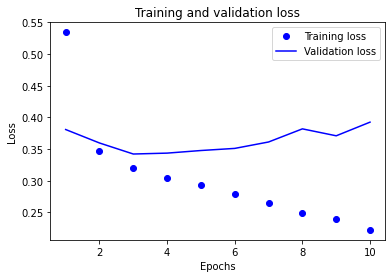

In [18]:
# loss 그래프

history_LSTM_dict = history_LSTM.history

acc = history_LSTM_dict['accuracy']
val_acc = history_LSTM_dict['val_accuracy']
loss = history_LSTM_dict['loss']
val_loss = history_LSTM_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

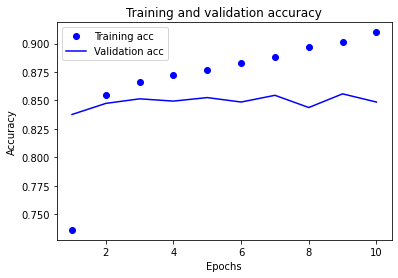

In [19]:
# accuracy 그래프

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc') # "bo"는 "파란색 점"
plt.plot(epochs, val_acc, 'b', label='Validation acc') # b는 "파란 실선"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# CNN

In [20]:
CNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_CNN = CNN.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
265/265 [==============================] - 7s 18ms/step - loss: 0.5953 - accuracy: 0.6558 - val_loss: 0.3670 - val_accuracy: 0.8357
Epoch 2/10
265/265 [==============================] - 2s 9ms/step - loss: 0.3280 - accuracy: 0.8609 - val_loss: 0.3314 - val_accuracy: 0.8515
Epoch 3/10
265/265 [==============================] - 2s 9ms/step - loss: 0.2836 - accuracy: 0.8836 - val_loss: 0.3309 - val_accuracy: 0.8552
Epoch 4/10
265/265 [==============================] - 2s 9ms/step - loss: 0.2504 - accuracy: 0.9004 - val_loss: 0.3440 - val_accuracy: 0.8535
Epoch 5/10
265/265 [==============================] - 2s 9ms/step - loss: 0.2051 - accuracy: 0.9230 - val_loss: 0.3669 - val_accuracy: 0.8518
Epoch 6/10
265/265 [==============================] - 2s 9ms/step - loss: 0.1642 - accuracy: 0.9418 - val_loss: 0.4112 - val_accuracy: 0.8455
Epoch 7/10
265/265 [==============================] - 2s 9ms/step - loss: 0.1297 - accuracy: 0.9564 - val_loss: 0.4798 - val_accuracy: 0.8403
Epoch

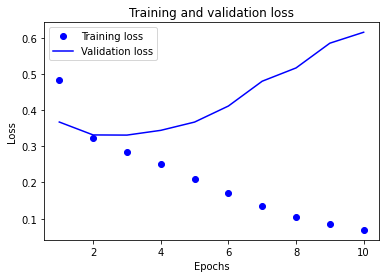

In [21]:
# loss 그래프

history_CNN_dict = history_CNN.history

acc = history_CNN_dict['accuracy']
val_acc = history_CNN_dict['val_accuracy']
loss = history_CNN_dict['loss']
val_loss = history_CNN_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

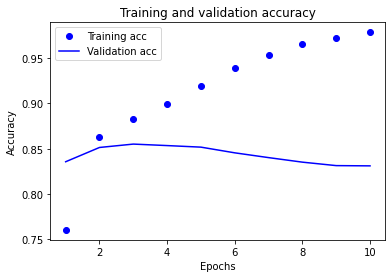

In [22]:
# accuracy 그래프

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc') # "bo"는 "파란색 점"
plt.plot(epochs, val_acc, 'b', label='Validation acc') # b는 "파란 실선"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## GlobalMaxPooling (1개)

In [23]:
Global.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_Global = Global.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
265/265 [==============================] - 3s 7ms/step - loss: 0.6342 - accuracy: 0.6801 - val_loss: 0.3768 - val_accuracy: 0.8334
Epoch 2/10
265/265 [==============================] - 2s 7ms/step - loss: 0.3535 - accuracy: 0.8492 - val_loss: 0.3396 - val_accuracy: 0.8512
Epoch 3/10
265/265 [==============================] - 2s 7ms/step - loss: 0.3058 - accuracy: 0.8724 - val_loss: 0.3360 - val_accuracy: 0.8541
Epoch 4/10
265/265 [==============================] - 2s 7ms/step - loss: 0.2753 - accuracy: 0.8881 - val_loss: 0.3401 - val_accuracy: 0.8516
Epoch 5/10
265/265 [==============================] - 2s 7ms/step - loss: 0.2533 - accuracy: 0.8988 - val_loss: 0.3460 - val_accuracy: 0.8521
Epoch 6/10
265/265 [==============================] - 2s 7ms/step - loss: 0.2298 - accuracy: 0.9093 - val_loss: 0.3557 - val_accuracy: 0.8517
Epoch 7/10
265/265 [==============================] - 2s 7ms/step - loss: 0.2121 - accuracy: 0.9177 - val_loss: 0.3687 - val_accuracy: 0.8517
Epoch 

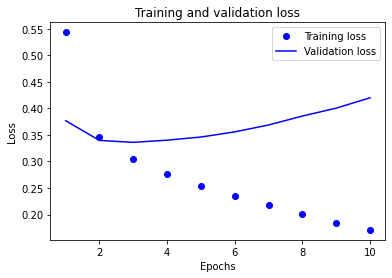

In [24]:
history_Global_dict = history_Global.history

acc = history_Global_dict['accuracy']
val_acc = history_Global_dict['val_accuracy']
loss = history_Global_dict['loss']
val_loss = history_Global_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

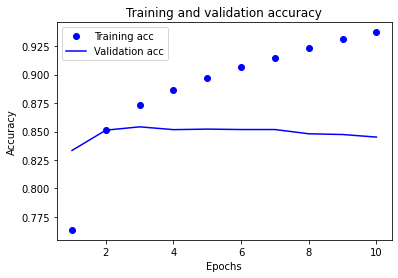

In [25]:
# accuracy 그래프

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc') # "bo"는 "파란색 점"
plt.plot(epochs, val_acc, 'b', label='Validation acc') # b는 "파란 실선"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Test

In [26]:
results_LSTM = LSTM.evaluate(X_test, y_test, verbose=2)
print(results_LSTM)

1537/1537 - 5s - loss: 0.4003 - accuracy: 0.8419
[0.4003068804740906, 0.8419146537780762]


In [27]:
results_CNN = CNN.evaluate(X_test, y_test, verbose=2)
print(results_CNN)

1537/1537 - 4s - loss: 0.6344 - accuracy: 0.8256
[0.6344394087791443, 0.8255792856216431]


In [28]:
results_Global = Global.evaluate(X_test, y_test, verbose=2)
print(results_Global)

1537/1537 - 2s - loss: 0.4377 - accuracy: 0.8395
[0.4376729428768158, 0.8394531607627869]


# 6. Embedding Layer 분석

## LSTM

In [29]:
import os
import os
from konlpy.tag import Mecab
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

embedding_LSTM = LSTM.layers[0]
weights_LSTM = embedding_LSTM.get_weights()[0]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_LSTM = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_LSTM.txt'
f = open(word2vec_file_path_LSTM, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = LSTM.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

print('done')

done


In [30]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있습니다.

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_LSTM, binary=False)
vector = word_vectors['고양이']
vector

array([-0.01818938,  0.00559709, -0.00629043,  0.02678846,  0.01668318,
       -0.02736607, -0.0415281 , -0.0005633 ,  0.06720448,  0.085428  ,
       -0.03170136,  0.02299126, -0.02253241,  0.0016394 ,  0.01217886,
        0.00653221, -0.0253763 , -0.02437554, -0.2957178 , -0.03523678,
        0.04610135,  0.06008962,  0.0028124 , -0.12474929, -0.01920794,
        0.00213786,  0.0029113 , -0.02203598, -0.01517432, -0.00870687,
       -0.08468394,  0.03875809], dtype=float32)

In [31]:
word_vectors.similar_by_word("최고")

[('통쾌', 0.9467792510986328),
 ('잠기', 0.9429609179496765),
 ('달랐', 0.9397703409194946),
 ('살아온', 0.9385436773300171),
 ('먹먹', 0.9346243143081665),
 ('친근', 0.9338467121124268),
 ('보석', 0.9337409734725952),
 ('노동자', 0.9326884150505066),
 ('은근', 0.9310290813446045),
 ('완벽', 0.9307490587234497)]

## CNN

In [32]:
embedding_CNN = CNN.layers[0]
weights_CNN = embedding_CNN.get_weights()[0]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_CNN = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_CNN.txt'
f = open(word2vec_file_path_CNN, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = CNN.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [33]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있습니다.

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_CNN, binary=False)
vector = word_vectors['최악']
vector

array([ 0.24124064,  0.16967632,  0.13827088,  0.1165504 ,  0.22243011,
        0.26042938,  0.11643023,  0.11523788, -0.14311102,  0.0763477 ,
       -0.22904925, -0.0723125 ,  0.18279403, -0.09512399, -0.16610831,
       -0.24029556,  0.03170658, -0.21841228,  0.2481501 , -0.25981265,
        0.18151054,  0.06818509,  0.1801727 , -0.0748177 , -0.15051301,
       -0.17689732,  0.23395623, -0.23294948,  0.14002553,  0.23226574,
       -0.1991841 ,  0.19069107], dtype=float32)

In [34]:
word_vectors.similar_by_word("최고")

[('제라드', 0.7855988144874573),
 ('밀리', 0.7767280340194702),
 ('흐뭇', 0.7557768821716309),
 ('이종혁', 0.7529381513595581),
 ('돌고래', 0.7508485317230225),
 ('서늘', 0.7478161454200745),
 ('해운대', 0.7454484701156616),
 ('무서', 0.7437072992324829),
 ('great', 0.7408009171485901),
 ('유전', 0.7404481172561646)]

## GlobalMaxPooling

In [35]:
embedding_Global = Global.layers[0]
weights_Global = embedding_Global.get_weights()[0]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_GMP = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_GMP.txt'
f = open(word2vec_file_path_GMP, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = Global.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [36]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있습니다.

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_GMP, binary=False)
vector = word_vectors['최악']
vector

array([ 0.00663756, -0.12017503,  0.23670326,  0.00105837, -0.08750764,
       -0.10210822, -0.11879785,  0.1648838 , -0.11575351, -0.07594588,
        0.01554765,  0.03414377, -0.12710582, -0.13313155,  0.04306092,
       -0.13076589,  0.21979603, -0.12262218, -0.07536671,  0.15183334,
       -0.12374371,  0.21542278,  0.21554406, -0.00847308, -0.04054115,
        0.2788148 , -0.10198608, -0.12791564, -0.14495246,  0.23480637,
       -0.13317361,  0.03936573], dtype=float32)

In [37]:
word_vectors.similar_by_word("최고")

[('찬사', 0.6730936765670776),
 ('68', 0.6519652605056763),
 ('할리', 0.6415063738822937),
 ('존경', 0.6332577466964722),
 ('돋보였', 0.6264127492904663),
 ('홀리', 0.6138744354248047),
 ('헷', 0.6059214472770691),
 ('숨소리', 0.5949921607971191),
 ('김민희', 0.5823412537574768),
 ('린치', 0.5728583335876465)]

# 7. 한국어 Word2Vec 임베딩 활용하여 성능개선
https://github.com/Kyubyong/wordvectors

In [38]:
path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = Word2Vec.load(path)
vector = word2vec['최고']
vector.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(200,)

In [39]:
print(word2vec.most_similar('사랑'))

[('슬픔', 0.7216662764549255), ('행복', 0.6759077310562134), ('절망', 0.6468985080718994), ('기쁨', 0.6458414196968079), ('이별', 0.6334798336029053), ('추억', 0.6320937275886536), ('인생', 0.6216273307800293), ('애정', 0.6206069588661194), ('연인', 0.6186063289642334), ('유혹', 0.5965287685394287)]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


In [40]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


## 적용한 채로 모델

In [42]:
# LSTM

LSTM = keras.Sequential()
LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
LSTM.add(keras.layers.LSTM(8))
LSTM.add(keras.layers.Dense(8, activation='relu'))
LSTM.add(keras.layers.Dense(1, activation='sigmoid'))

LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [43]:
# CNN

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [45]:
# GlobalMaxPooling

Global = keras.Sequential()
Global.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
Global.add(keras.layers.GlobalMaxPooling1D())
Global.add(keras.layers.Dense(8, activation='relu'))
Global.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

Global.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [46]:
LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_LSTM = LSTM.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
265/265 [==============================] - 9s 29ms/step - loss: 0.6918 - accuracy: 0.5071 - val_loss: 0.6908 - val_accuracy: 0.5099
Epoch 2/10
265/265 [==============================] - 7s 27ms/step - loss: 0.6803 - accuracy: 0.5278 - val_loss: 0.4649 - val_accuracy: 0.7967
Epoch 3/10
265/265 [==============================] - 7s 27ms/step - loss: 0.4254 - accuracy: 0.8170 - val_loss: 0.3641 - val_accuracy: 0.8422
Epoch 4/10
265/265 [==============================] - 7s 26ms/step - loss: 0.3363 - accuracy: 0.8586 - val_loss: 0.3434 - val_accuracy: 0.8498
Epoch 5/10
265/265 [==============================] - 7s 26ms/step - loss: 0.3070 - accuracy: 0.8733 - val_loss: 0.3426 - val_accuracy: 0.8549
Epoch 6/10
265/265 [==============================] - 7s 27ms/step - loss: 0.2861 - accuracy: 0.8827 - val_loss: 0.3402 - val_accuracy: 0.8560
Epoch 7/10
265/265 [==============================] - 7s 27ms/step - loss: 0.2714 - accuracy: 0.8899 - val_loss: 0.3374 - val_accuracy: 0.8574

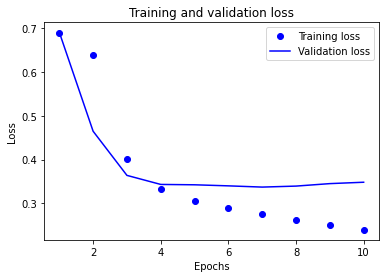

In [47]:
# loss 그래프

history_LSTM_dict = history_LSTM.history

acc = history_LSTM_dict['accuracy']
val_acc = history_LSTM_dict['val_accuracy']
loss = history_LSTM_dict['loss']
val_loss = history_LSTM_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

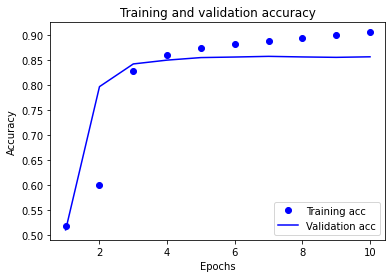

In [48]:
# accuracy 그래프

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc') # "bo"는 "파란색 점"
plt.plot(epochs, val_acc, 'b', label='Validation acc') # b는 "파란 실선"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [49]:
CNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_CNN = CNN.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
265/265 [==============================] - 3s 10ms/step - loss: 0.0559 - accuracy: 0.9825 - val_loss: 0.6686 - val_accuracy: 0.8293
Epoch 2/10
265/265 [==============================] - 2s 9ms/step - loss: 0.0450 - accuracy: 0.9863 - val_loss: 0.7600 - val_accuracy: 0.8268
Epoch 3/10
265/265 [==============================] - 2s 9ms/step - loss: 0.0378 - accuracy: 0.9882 - val_loss: 0.8129 - val_accuracy: 0.8235
Epoch 4/10
265/265 [==============================] - 2s 9ms/step - loss: 0.0310 - accuracy: 0.9905 - val_loss: 0.9289 - val_accuracy: 0.8171
Epoch 5/10
265/265 [==============================] - 2s 9ms/step - loss: 0.0308 - accuracy: 0.9904 - val_loss: 0.9662 - val_accuracy: 0.8190
Epoch 6/10
265/265 [==============================] - 2s 9ms/step - loss: 0.0271 - accuracy: 0.9914 - val_loss: 0.9890 - val_accuracy: 0.8226
Epoch 7/10
265/265 [==============================] - 2s 9ms/step - loss: 0.0243 - accuracy: 0.9923 - val_loss: 1.0133 - val_accuracy: 0.8224
Epoch

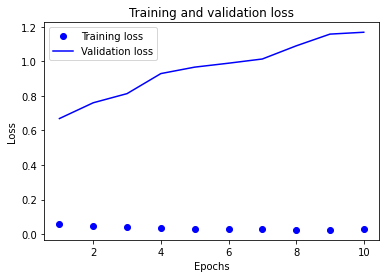

In [51]:
history_CNN_dict = history_CNN.history

acc = history_CNN_dict['accuracy']
val_acc = history_CNN_dict['val_accuracy']
loss = history_CNN_dict['loss']
val_loss = history_CNN_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


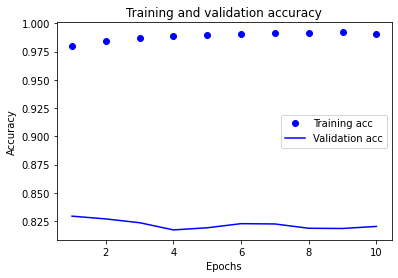

In [52]:
# accuracy 그래프

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc') # "bo"는 "파란색 점"
plt.plot(epochs, val_acc, 'b', label='Validation acc') # b는 "파란 실선"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [54]:
Global.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_Global = Global.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
265/265 [==============================] - 7s 23ms/step - loss: 0.6945 - accuracy: 0.5419 - val_loss: 0.5985 - val_accuracy: 0.6777
Epoch 2/10
265/265 [==============================] - 6s 22ms/step - loss: 0.5661 - accuracy: 0.7067 - val_loss: 0.5162 - val_accuracy: 0.7481
Epoch 3/10
265/265 [==============================] - 6s 23ms/step - loss: 0.4940 - accuracy: 0.7610 - val_loss: 0.4770 - val_accuracy: 0.7738
Epoch 4/10
265/265 [==============================] - 6s 23ms/step - loss: 0.4463 - accuracy: 0.7913 - val_loss: 0.4554 - val_accuracy: 0.7845
Epoch 5/10
265/265 [==============================] - 6s 22ms/step - loss: 0.4180 - accuracy: 0.8083 - val_loss: 0.4227 - val_accuracy: 0.8047
Epoch 6/10
265/265 [==============================] - 6s 23ms/step - loss: 0.3881 - accuracy: 0.8263 - val_loss: 0.4086 - val_accuracy: 0.8138
Epoch 7/10
265/265 [==============================] - 6s 22ms/step - loss: 0.3690 - accuracy: 0.8379 - val_loss: 0.3989 - val_accuracy: 0.8177

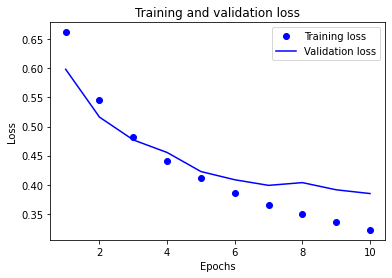

In [56]:
history_Global_dict = history_Global.history

acc = history_Global_dict['accuracy']
val_acc = history_Global_dict['val_accuracy']
loss = history_Global_dict['loss']
val_loss = history_Global_dict['val_loss']

epochs = range(1, len(acc) + 1)

# loss 그래프

plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

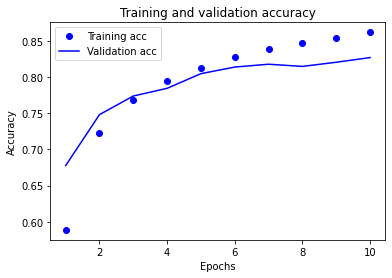

In [57]:
# accuracy 그래프

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc') # "bo"는 "파란색 점"
plt.plot(epochs, val_acc, 'b', label='Validation acc') # b는 "파란 실선"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [58]:
# 테스트

results_LSTM = LSTM.evaluate(X_test, y_test, verbose=2)
print(results_LSTM)

1537/1537 - 5s - loss: 0.3631 - accuracy: 0.8492
[0.36308032274246216, 0.8491567969322205]


In [59]:
results_CNN = CNN.evaluate(X_test, y_test, verbose=2)
print(results_CNN)

1537/1537 - 3s - loss: 1.1754 - accuracy: 0.8185
[1.1754488945007324, 0.8185405731201172]


In [60]:
results_Global = Global.evaluate(X_test, y_test, verbose=2)
print(results_Global)

1537/1537 - 3s - loss: 0.4004 - accuracy: 0.8221
[0.4004356563091278, 0.8220802545547485]


## LSTM이 가장 가능성이 있어보여서 파라미터 수정하고 다시 진행

In [61]:
# LSTM

LSTM = keras.Sequential()
LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
LSTM.add(keras.layers.LSTM(128)) ## << 128로 수정
LSTM.add(keras.layers.Dense(8, activation='relu'))
LSTM.add(keras.layers.Dense(1, activation='sigmoid'))

LSTM.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [62]:
LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_LSTM = LSTM.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
265/265 [==============================] - 14s 45ms/step - loss: 0.6188 - accuracy: 0.6047 - val_loss: 0.3864 - val_accuracy: 0.8255
Epoch 2/10
265/265 [==============================] - 11s 43ms/step - loss: 0.3528 - accuracy: 0.8456 - val_loss: 0.3265 - val_accuracy: 0.8561
Epoch 3/10
265/265 [==============================] - 11s 43ms/step - loss: 0.2918 - accuracy: 0.8766 - val_loss: 0.3186 - val_accuracy: 0.8587
Epoch 4/10
265/265 [==============================] - 11s 43ms/step - loss: 0.2654 - accuracy: 0.8908 - val_loss: 0.3167 - val_accuracy: 0.8651
Epoch 5/10
265/265 [==============================] - 11s 43ms/step - loss: 0.2444 - accuracy: 0.9001 - val_loss: 0.3203 - val_accuracy: 0.8629
Epoch 6/10
265/265 [==============================] - 11s 43ms/step - loss: 0.2145 - accuracy: 0.9145 - val_loss: 0.3542 - val_accuracy: 0.8499
Epoch 7/10
265/265 [==============================] - 11s 43ms/step - loss: 0.2073 - accuracy: 0.9163 - val_loss: 0.3593 - val_accuracy:

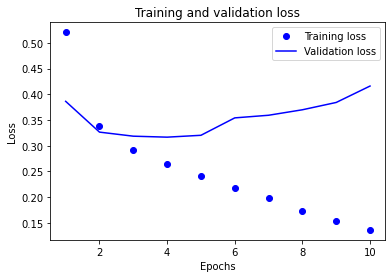

In [63]:
# loss 그래프

history_LSTM_dict = history_LSTM.history

acc = history_LSTM_dict['accuracy']
val_acc = history_LSTM_dict['val_accuracy']
loss = history_LSTM_dict['loss']
val_loss = history_LSTM_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

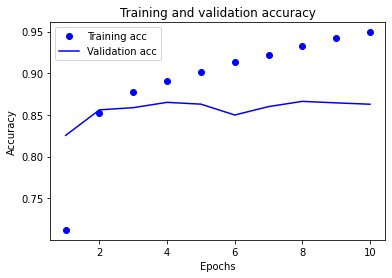

In [64]:
# accuracy 그래프

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc') # "bo"는 "파란색 점"
plt.plot(epochs, val_acc, 'b', label='Validation acc') # b는 "파란 실선"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [65]:
# 테스트

results_LSTM = LSTM.evaluate(X_test, y_test, verbose=2)
print(results_LSTM)

1537/1537 - 6s - loss: 0.4247 - accuracy: 0.8563
[0.4247119724750519, 0.8562564849853516]


### LSTM state 벡터의 차원 수를 128로 수정하고 나니 정확도 85% 달성!!

In [66]:
embedding_LSTM = LSTM.layers[0]
weights_LSTM = embedding_LSTM.get_weights()[0]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_LSTM = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_LSTM.txt'
f = open(word2vec_file_path_LSTM, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = LSTM.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

print('done')

done


In [67]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있습니다.

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_LSTM, binary=False)
vector = word_vectors['고양이']
vector

array([ 2.631299  , -1.193238  ,  0.07540613,  1.0229442 , -1.7202556 ,
       -0.50753736,  0.05576998,  1.4526403 ,  0.50852096,  0.95807093,
        1.5839341 , -0.11637137,  0.70676017, -0.6180123 ,  0.6220214 ,
       -0.2458321 ,  0.07776082,  0.7441544 ,  0.25204363, -0.0477558 ,
        0.17199631, -0.64556456,  1.1676369 , -0.05842115, -1.607617  ,
       -1.3464723 ,  3.0851324 ,  1.5510999 , -0.8019187 , -2.2755258 ,
        1.0895963 ,  0.48994446,  0.6972382 ,  0.6498299 ,  1.1230313 ,
       -0.3143906 , -0.59378904,  0.29937693, -0.63988733,  0.412478  ,
       -1.0666589 ,  1.039204  , -0.82585484, -1.9971424 , -0.29346296,
       -1.311904  , -0.6912591 , -0.11509009, -0.8158489 , -0.01456762,
        0.6384633 ,  0.7701224 , -0.00522803,  0.36162272, -2.123445  ,
       -0.18213376, -0.977647  ,  0.08282149,  0.23708488,  0.8724221 ,
        0.31931302,  0.666353  , -0.21132927, -1.2832081 ,  0.4856813 ,
        0.2858947 ,  0.24568845,  0.19413555,  0.7212137 ,  0.73

In [68]:
word_vectors.similar_by_word("최고")

[('최대', 0.5583852529525757),
 ('최강', 0.523967981338501),
 ('최상', 0.45638376474380493),
 ('최초', 0.4475148916244507),
 ('손꼽히', 0.44311678409576416),
 ('올해', 0.4251411557197571),
 ('일류', 0.4153048098087311),
 ('역대', 0.41045090556144714),
 ('으뜸', 0.3851609230041504),
 ('최악', 0.380142480134964)]

In [69]:
word_vectors.similar_by_word("사랑")

[('슬픔', 0.7157237529754639),
 ('행복', 0.681169867515564),
 ('기쁨', 0.6466604471206665),
 ('절망', 0.6333852410316467),
 ('이별', 0.6301339864730835),
 ('인생', 0.6198372840881348),
 ('애정', 0.6191928386688232),
 ('추억', 0.6160914897918701),
 ('연인', 0.6051567792892456),
 ('고독', 0.597561240196228)]

In [71]:
word_vectors.similar_by_word("감독")

[('코치', 0.5716990232467651),
 ('각본', 0.5159938931465149),
 ('주연', 0.5152431726455688),
 ('스턴트', 0.5105217695236206),
 ('히치콕', 0.5104566812515259),
 ('연출가', 0.47697216272354126),
 ('영화배우', 0.4691927433013916),
 ('제작자', 0.46903932094573975),
 ('매니저', 0.4567965567111969),
 ('앤더슨', 0.44461071491241455)]

### 아주 성공적으로 나온다!!! 